# Fitting remaining ion current conductances

Using full AP/CaT measures to fit the remaining conductances.

# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Generate samples of ABC channel results

In [5]:
history = {'icat': History('sqlite:///results/icat/hl-1_icat.db'),
           'ical': History('sqlite:///results/ical/hl-1_ical.db'),
           'ina': History('sqlite:///results/ina/hl-1_ina.db'),
           'ikr': History('sqlite:///results/ikr/hl-1_ikr.db'),
           'ikur': History('sqlite:///results/ikur/hl-1_ikur.db'),
           'ito': History('sqlite:///results/ito/hl-1_ito.db'),
           'iha': History('sqlite:///results/iha/hl-1_iha.db'),
           'ik1': History('sqlite:///results/ik1/hl-1_ik1.db')}

In [6]:
# Set to correct result (last ABC run in database).
for _,h in history.items():
    h.id = len(h.all_runs())

In [7]:
# Generate a sample from all history items.
def generate_sample(history, n):
    samples = [dict() for i in range(n)]
    for k, h in history.items():
        dist = h.get_distribution(m=0)
        weights = dist[1]
        ch_samples = dist[0] \
                    .sample(n, weights=weights, replace=True) \
                    .to_dict(orient='records')
        ch_samples = [{k+'.'+key: value for key, value in ch.items()}
                      for ch in ch_samples]
        for c, s in zip(ch_samples, samples):
            s.update(c)
    return samples

In [8]:
# Generate samples
n_samples = 100
param_samples = generate_sample(history, n_samples)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [9]:
from channels.hl1 import hl1 as model

In [10]:
# Targets from Dias, 2014 from HL1-6 myocyte
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

In [11]:
# Treat each entry as a separate experiment
for k, _ in exp.items():
    exp[k] = k

In [12]:
limits = {'ik1.g_K1': (0, 0.1),
          'incx.k_NCX': (0, 10),
          'icab.g_Cab': (0, 0.001),
          'inab.g_Nab': (0, 0.01),
          'inak.i_NaK_max': (0, 10),
          'serca.V_max': (0, 10),
          'ca_diffusion.tau_tr': (0, 1000)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [13]:
macro_parameters = [k for k in limits.keys()]

In [14]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

# Create 'training' dataset of 'macro' parameters from ABC parameter samples

In [15]:
from ionchannelABC import generate_training_data

In [16]:
X, Y = generate_training_data(macro_parameters,
                              param_samples,
                              model,
                              distance_fn,
                              limits=limits,
                              disp=True,
                              workers=24,
                              optimise_args={'updating': 'deferred',
                                             'tol': 0.05})

=> Running ABC sample 0...
differential_evolution step 1: f(x)= 100.277
differential_evolution step 2: f(x)= 100.277
differential_evolution step 3: f(x)= 75.1907
differential_evolution step 4: f(x)= 75.1907
differential_evolution step 5: f(x)= 75.1907
differential_evolution step 6: f(x)= 75.1907
differential_evolution step 7: f(x)= 75.1907
differential_evolution step 8: f(x)= 48.1949
differential_evolution step 9: f(x)= 48.1949
differential_evolution step 10: f(x)= 48.1949
differential_evolution step 11: f(x)= 48.1949
differential_evolution step 12: f(x)= 48.1949
differential_evolution step 13: f(x)= 48.1949
differential_evolution step 14: f(x)= 48.1949
differential_evolution step 15: f(x)= 46.6903
differential_evolution step 16: f(x)= 46.6903
differential_evolution step 17: f(x)= 46.6903
differential_evolution step 18: f(x)= 46.6903
differential_evolution step 19: f(x)= 46.6903
differential_evolution step 20: f(x)= 46.6903
differential_evolution step 21: f(x)= 46.4016
differential_evo

differential_evolution step 9: f(x)= 80.315
differential_evolution step 10: f(x)= 72.4987
differential_evolution step 11: f(x)= 70.1658
differential_evolution step 12: f(x)= 65.3125
differential_evolution step 13: f(x)= 65.3125
differential_evolution step 14: f(x)= 54.6524
differential_evolution step 15: f(x)= 54.6524
differential_evolution step 16: f(x)= 54.6524
differential_evolution step 17: f(x)= 54.6524
differential_evolution step 18: f(x)= 54.6524
differential_evolution step 19: f(x)= 44.3579
differential_evolution step 20: f(x)= 44.3579
differential_evolution step 21: f(x)= 44.3579
differential_evolution step 22: f(x)= 44.3579
differential_evolution step 23: f(x)= 44.3579
differential_evolution step 24: f(x)= 44.3579
differential_evolution step 25: f(x)= 44.3579
differential_evolution step 26: f(x)= 44.3579
differential_evolution step 27: f(x)= 44.3579
differential_evolution step 28: f(x)= 44.3579
differential_evolution step 29: f(x)= 44.3579
differential_evolution step 30: f(x)

differential_evolution step 29: f(x)= 52.9459
differential_evolution step 30: f(x)= 52.9459
differential_evolution step 31: f(x)= 52.9459
differential_evolution step 32: f(x)= 52.0071
differential_evolution step 33: f(x)= 52.0071
differential_evolution step 34: f(x)= 52.0071
differential_evolution step 35: f(x)= 52.0071
differential_evolution step 36: f(x)= 52.0071
differential_evolution step 37: f(x)= 51.5481
differential_evolution step 38: f(x)= 50.7451
differential_evolution step 39: f(x)= 49.8648
differential_evolution step 40: f(x)= 49.8648
differential_evolution step 41: f(x)= 49.6629
differential_evolution step 42: f(x)= 49.6629
differential_evolution step 43: f(x)= 49.2968
differential_evolution step 44: f(x)= 49.2968
differential_evolution step 45: f(x)= 49.2968
=> Running ABC sample 8...
differential_evolution step 1: f(x)= 105.925
differential_evolution step 2: f(x)= 96.218
differential_evolution step 3: f(x)= 91.0373
differential_evolution step 4: f(x)= 85.0429
differential

differential_evolution step 50: f(x)= 38.1199
differential_evolution step 51: f(x)= 38.0089
differential_evolution step 52: f(x)= 37.6415
differential_evolution step 53: f(x)= 37.6415
differential_evolution step 54: f(x)= 37.6415
=> Running ABC sample 12...
differential_evolution step 1: f(x)= 77.5695
differential_evolution step 2: f(x)= 72.0357
differential_evolution step 3: f(x)= 63.1826
differential_evolution step 4: f(x)= 63.1826
differential_evolution step 5: f(x)= 63.1826
differential_evolution step 6: f(x)= 63.1826
differential_evolution step 7: f(x)= 63.1826
differential_evolution step 8: f(x)= 63.1826
differential_evolution step 9: f(x)= 63.1826
differential_evolution step 10: f(x)= 42.6177
differential_evolution step 11: f(x)= 42.6177
differential_evolution step 12: f(x)= 42.6177
differential_evolution step 13: f(x)= 39.6806
differential_evolution step 14: f(x)= 39.6806
differential_evolution step 15: f(x)= 39.6806
differential_evolution step 16: f(x)= 39.6806
differential_ev

differential_evolution step 22: f(x)= 103.244
differential_evolution step 23: f(x)= 103.244
differential_evolution step 24: f(x)= 103.244
differential_evolution step 25: f(x)= 103.244
differential_evolution step 26: f(x)= 103.244
differential_evolution step 27: f(x)= 103.244
differential_evolution step 28: f(x)= 100.91
differential_evolution step 29: f(x)= 100.91
differential_evolution step 30: f(x)= 100.91
differential_evolution step 31: f(x)= 100.91
differential_evolution step 32: f(x)= 100.91
differential_evolution step 33: f(x)= 100.91
differential_evolution step 34: f(x)= 100.91
differential_evolution step 35: f(x)= 100.91
=> Running ABC sample 16...
differential_evolution step 1: f(x)= 125.3
differential_evolution step 2: f(x)= 124.046
differential_evolution step 3: f(x)= 122.445
differential_evolution step 4: f(x)= 116.666
differential_evolution step 5: f(x)= 108.089
differential_evolution step 6: f(x)= 108.089
differential_evolution step 7: f(x)= 108.089
differential_evolution 

differential_evolution step 20: f(x)= 53.2399
differential_evolution step 21: f(x)= 53.2399
differential_evolution step 22: f(x)= 53.2399
differential_evolution step 23: f(x)= 53.2399
differential_evolution step 24: f(x)= 53.2399
differential_evolution step 25: f(x)= 53.2399
differential_evolution step 26: f(x)= 53.2399
differential_evolution step 27: f(x)= 53.2399
differential_evolution step 28: f(x)= 53.2399
differential_evolution step 29: f(x)= 53.2399
differential_evolution step 30: f(x)= 53.2399
differential_evolution step 31: f(x)= 53.2399
differential_evolution step 32: f(x)= 53.2399
differential_evolution step 33: f(x)= 53.2399
differential_evolution step 34: f(x)= 53.1394
differential_evolution step 35: f(x)= 53.0732
differential_evolution step 36: f(x)= 53.0732
differential_evolution step 37: f(x)= 53.0732
differential_evolution step 38: f(x)= 53.0732
differential_evolution step 39: f(x)= 52.8436
differential_evolution step 40: f(x)= 52.8436
differential_evolution step 41: f(

differential_evolution step 8: f(x)= 74.6199
differential_evolution step 9: f(x)= 73.0838
differential_evolution step 10: f(x)= 73.0838
differential_evolution step 11: f(x)= 73.0838
differential_evolution step 12: f(x)= 73.0838
differential_evolution step 13: f(x)= 70.2265
differential_evolution step 14: f(x)= 70.2265
differential_evolution step 15: f(x)= 70.2265
differential_evolution step 16: f(x)= 70.2265
differential_evolution step 17: f(x)= 70.2265
differential_evolution step 18: f(x)= 65.5141
differential_evolution step 19: f(x)= 64.9912
differential_evolution step 20: f(x)= 64.9912
differential_evolution step 21: f(x)= 64.9912
differential_evolution step 22: f(x)= 64.9912
differential_evolution step 23: f(x)= 62.9397
differential_evolution step 24: f(x)= 62.9397
differential_evolution step 25: f(x)= 62.9397
differential_evolution step 26: f(x)= 62.9397
differential_evolution step 27: f(x)= 62.9397
differential_evolution step 28: f(x)= 62.9397
differential_evolution step 29: f(x)

differential_evolution step 45: f(x)= 26.1132
differential_evolution step 46: f(x)= 26.1132
differential_evolution step 47: f(x)= 26.1132
differential_evolution step 48: f(x)= 26.1132
differential_evolution step 49: f(x)= 26.1132
differential_evolution step 50: f(x)= 26.1132
differential_evolution step 51: f(x)= 26.1132
differential_evolution step 52: f(x)= 26.1132
differential_evolution step 53: f(x)= 26.1132
differential_evolution step 54: f(x)= 26.1132
differential_evolution step 55: f(x)= 26.1132
differential_evolution step 56: f(x)= 26.1132
differential_evolution step 57: f(x)= 26.1132
differential_evolution step 58: f(x)= 26.0149
differential_evolution step 59: f(x)= 26.0149
differential_evolution step 60: f(x)= 26.0149
differential_evolution step 61: f(x)= 26.0149
=> Running ABC sample 26...
differential_evolution step 1: f(x)= 85.1685
differential_evolution step 2: f(x)= 85.1685
differential_evolution step 3: f(x)= 81.986
differential_evolution step 4: f(x)= 64.5541
differentia

differential_evolution step 15: f(x)= 88.5851
differential_evolution step 16: f(x)= 84.9173
differential_evolution step 17: f(x)= 84.9173
differential_evolution step 18: f(x)= 84.9173
differential_evolution step 19: f(x)= 84.9173
differential_evolution step 20: f(x)= 84.9173
differential_evolution step 21: f(x)= 84.9173
differential_evolution step 22: f(x)= 83.148
differential_evolution step 23: f(x)= 83.148
differential_evolution step 24: f(x)= 83.148
differential_evolution step 25: f(x)= 83.148
differential_evolution step 26: f(x)= 83.148
differential_evolution step 27: f(x)= 83.148
differential_evolution step 28: f(x)= 83.148
differential_evolution step 29: f(x)= 83.148
differential_evolution step 30: f(x)= 83.148
differential_evolution step 31: f(x)= 74.7399
differential_evolution step 32: f(x)= 74.7399
differential_evolution step 33: f(x)= 74.7399
differential_evolution step 34: f(x)= 74.7399
differential_evolution step 35: f(x)= 74.7399
differential_evolution step 36: f(x)= 74.73

differential_evolution step 192: f(x)= 56.4254
differential_evolution step 193: f(x)= 56.4254
differential_evolution step 194: f(x)= 56.4254
differential_evolution step 195: f(x)= 56.4254
differential_evolution step 196: f(x)= 56.4254
differential_evolution step 197: f(x)= 56.4254
differential_evolution step 198: f(x)= 56.4254
differential_evolution step 199: f(x)= 56.4254
differential_evolution step 200: f(x)= 56.4254
differential_evolution step 201: f(x)= 56.4254
differential_evolution step 202: f(x)= 56.4254
differential_evolution step 203: f(x)= 56.4254
differential_evolution step 204: f(x)= 56.4254
differential_evolution step 205: f(x)= 56.4254
differential_evolution step 206: f(x)= 56.4254
differential_evolution step 207: f(x)= 56.4254
differential_evolution step 208: f(x)= 56.4254
differential_evolution step 209: f(x)= 56.4254
differential_evolution step 210: f(x)= 56.4254
differential_evolution step 211: f(x)= 56.4254
differential_evolution step 212: f(x)= 56.4254
differential_

differential_evolution step 28: f(x)= 149.729
differential_evolution step 29: f(x)= 149.729
differential_evolution step 30: f(x)= 149.729
differential_evolution step 31: f(x)= 149.729
differential_evolution step 32: f(x)= 149.729
differential_evolution step 33: f(x)= 149.729
differential_evolution step 34: f(x)= 149.729
differential_evolution step 35: f(x)= 149.729
differential_evolution step 36: f(x)= 149.729
differential_evolution step 37: f(x)= 149.729
differential_evolution step 38: f(x)= 149.05
differential_evolution step 39: f(x)= 149.05
differential_evolution step 40: f(x)= 148.72
differential_evolution step 41: f(x)= 147.191
differential_evolution step 42: f(x)= 147.191
differential_evolution step 43: f(x)= 147.191
differential_evolution step 44: f(x)= 147.191
differential_evolution step 45: f(x)= 147.191
differential_evolution step 46: f(x)= 147.191
differential_evolution step 47: f(x)= 147.191
differential_evolution step 48: f(x)= 147.191
differential_evolution step 49: f(x)=

differential_evolution step 21: f(x)= 76.1366
differential_evolution step 22: f(x)= 76.1366
differential_evolution step 23: f(x)= 74.6582
differential_evolution step 24: f(x)= 74.6582
differential_evolution step 25: f(x)= 73.607
differential_evolution step 26: f(x)= 73.607
differential_evolution step 27: f(x)= 73.607
differential_evolution step 28: f(x)= 73.607
differential_evolution step 29: f(x)= 73.607
differential_evolution step 30: f(x)= 73.607
differential_evolution step 31: f(x)= 73.607
differential_evolution step 32: f(x)= 73.607
differential_evolution step 33: f(x)= 73.607
differential_evolution step 34: f(x)= 73.607
differential_evolution step 35: f(x)= 73.607
differential_evolution step 36: f(x)= 73.607
=> Running ABC sample 32...
differential_evolution step 1: f(x)= 144.052
differential_evolution step 2: f(x)= 144.052
differential_evolution step 3: f(x)= 123.818
differential_evolution step 4: f(x)= 113.402
differential_evolution step 5: f(x)= 107.266
differential_evolution 

differential_evolution step 82: f(x)= 78.176
differential_evolution step 83: f(x)= 78.176
differential_evolution step 84: f(x)= 78.176
differential_evolution step 85: f(x)= 78.176
differential_evolution step 86: f(x)= 78.176
differential_evolution step 87: f(x)= 78.176
differential_evolution step 88: f(x)= 78.176
differential_evolution step 89: f(x)= 78.176
differential_evolution step 90: f(x)= 77.7474
differential_evolution step 91: f(x)= 76.9424
differential_evolution step 92: f(x)= 76.9424
differential_evolution step 93: f(x)= 76.9424
=> Running ABC sample 39...
differential_evolution step 1: f(x)= 93.6838
differential_evolution step 2: f(x)= 92.2024
differential_evolution step 3: f(x)= 83.4975
differential_evolution step 4: f(x)= 76.2457
differential_evolution step 5: f(x)= 74.3286
differential_evolution step 6: f(x)= 74.3286
differential_evolution step 7: f(x)= 74.3286
differential_evolution step 8: f(x)= 73.2043
differential_evolution step 9: f(x)= 73.2043
differential_evolution 

=> Running ABC sample 42...
differential_evolution step 1: f(x)= 99.4571
differential_evolution step 2: f(x)= 99.4571
differential_evolution step 3: f(x)= 99.4571
differential_evolution step 4: f(x)= 98.4706
differential_evolution step 5: f(x)= 92.7276
differential_evolution step 6: f(x)= 87.3
differential_evolution step 7: f(x)= 86.6732
differential_evolution step 8: f(x)= 86.6732
differential_evolution step 9: f(x)= 83.3616
differential_evolution step 10: f(x)= 83.3616
differential_evolution step 11: f(x)= 83.3616
differential_evolution step 12: f(x)= 83.3616
differential_evolution step 13: f(x)= 83.3616
differential_evolution step 14: f(x)= 81.7392
differential_evolution step 15: f(x)= 81.7392
differential_evolution step 16: f(x)= 80.8253
differential_evolution step 17: f(x)= 80.8253
differential_evolution step 18: f(x)= 80.8253
differential_evolution step 19: f(x)= 80.8253
differential_evolution step 20: f(x)= 80.8253
differential_evolution step 21: f(x)= 80.8253
differential_evolu

differential_evolution step 32: f(x)= 68.0059
differential_evolution step 33: f(x)= 67.7405
differential_evolution step 34: f(x)= 66.7644
differential_evolution step 35: f(x)= 66.7644
differential_evolution step 36: f(x)= 66.7644
differential_evolution step 37: f(x)= 66.7644
differential_evolution step 38: f(x)= 66.7644
differential_evolution step 39: f(x)= 66.7644
=> Running ABC sample 47...
differential_evolution step 1: f(x)= 68.1691
differential_evolution step 2: f(x)= 68.1691
differential_evolution step 3: f(x)= 68.1691
differential_evolution step 4: f(x)= 61.6661
differential_evolution step 5: f(x)= 61.6661
differential_evolution step 6: f(x)= 61.6661
differential_evolution step 7: f(x)= 61.6661
differential_evolution step 8: f(x)= 61.6661
differential_evolution step 9: f(x)= 61.6661
differential_evolution step 10: f(x)= 61.6661
differential_evolution step 11: f(x)= 58.4125
differential_evolution step 12: f(x)= 53.989
differential_evolution step 13: f(x)= 53.989
differential_evol

Process Process-1245:
Process Process-1237:
Process Process-1246:
Process Process-1233:
Process Process-1231:
Process Process-1232:
Process Process-1243:
Process Process-1236:
Process Process-1240:
Process Process-1235:
Process Process-1247:
Process Process-1241:
Process Process-1244:
Process Process-1234:
Process Process-1242:
Process Process-1239:
Process Process-1228:
Process Process-1248:
Process Process-1225:
Process Process-1238:
Process Process-1229:
Process Process-1227:
Process Process-1226:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Trac

  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/concurrent/futures/process.py", line 169, in _process_worker
    call_item = call_queue.get(block=True)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/concurrent/futures/process.py", line 169, in _process_worker
    call_item = call_queue.get(block=True)
  File "/scratch/cph

  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Ke

KeyboardInterrupt: 

In [130]:
# Save my data!
import pickle
with open('macro_parameter_training.pkl', 'wb') as f:
    pickle.dump([X, Y], f)

In [15]:
# Load my data
#import pickle
#with open('macro_parameter_training.pkl', 'rb') as f:
#    X, Y = pickle.load(f)

In [19]:
Xnorm = np.divide(X-np.mean(X, axis=0), np.std(X, axis=0))
Ynorm = np.divide(Y-np.mean(Y, axis=0), np.std(Y, axis=0))

# Fit model (LinReg and EN) to training dataset

In [16]:
from sklearn.linear_model import LinearRegression, MultiTaskElasticNetCV
from sklearn.model_selection import cross_val_predict, cross_val_score

In [17]:
reg = LinearRegression()
en = MultiTaskElasticNetCV(l1_ratio=[.1, .3, .5, .75, .8, .9, .95, .98, .99, 1.],
                           cv=5,
                           n_jobs=9)

In [18]:
en.fit(X, Y)

MultiTaskElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001,
           fit_intercept=True,
           l1_ratio=[0.1, 0.3, 0.5, 0.75, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0],
           max_iter=1000, n_alphas=100, n_jobs=9, normalize=False,
           random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [22]:
cross_val_score(reg, X, Y, cv=3)

array([-27.96507404,  -2.94965323, -15.39916365])

In [25]:
cross_val_score(en, X, Y, cv=3)

array([-0.50250943,  0.17035385,  0.17855704])

In [24]:
Ypred = cross_val_predict(en, X, Y, cv=3)

In [25]:
df = pd.DataFrame(Y, columns=macro_parameters)
dfpred = pd.DataFrame(Ypred, columns=macro_parameters)
df = df.melt()
dfpred = dfpred.melt()
df = df.rename({'value': 'true'}, axis='columns')
df['pred'] = dfpred['value']

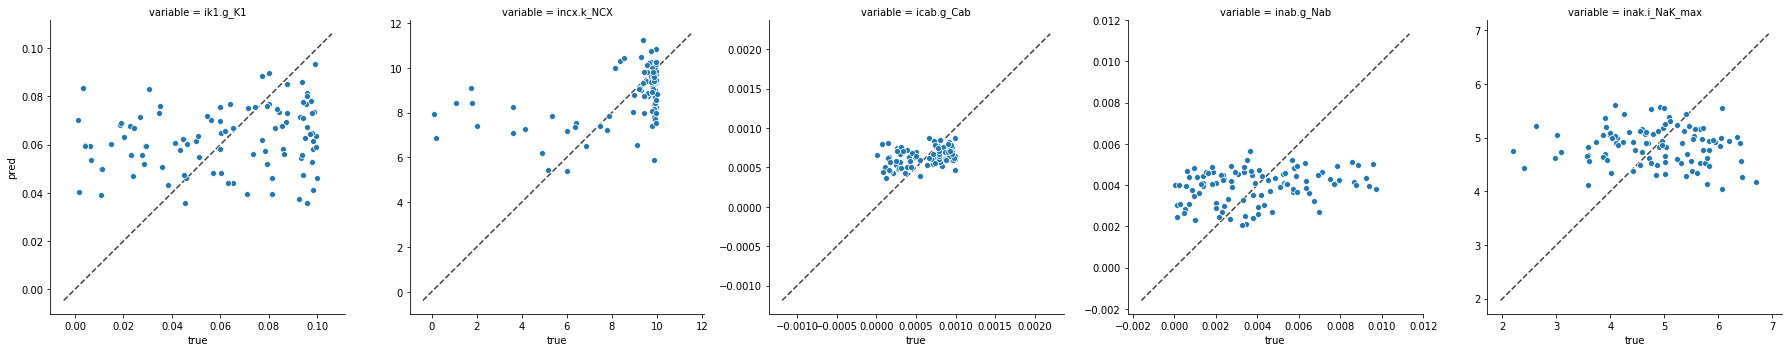

In [26]:
# Analyse fit
grid = sns.relplot(x='true', y='pred', col='variable', data=df, facet_kws={'sharex': False, 'sharey': False})
for i, ax in enumerate(grid.axes.flatten()):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    #ax.set_title('r2 score={r2:.2f}'.format(r2=en[i].score(Xnorm, Ynorm[:, i])))

# Create the full cell model for ABC

In [21]:
#model.add_external_par_samples(param_samples)

In [19]:
sample = np.random.choice(param_samples)

In [20]:
macro_predicted = en.predict(np.array(list(sample.values())).reshape(1, -1))
macro_params = dict(zip(macro_parameters, macro_predicted[0]))

In [22]:
model.sample(sample)

,x,y,exp
0,v_rest,-72.330307,0
1,Ca_i,0.284629,0
2,Na_i,17047.747444,0
3,K_i,119974.995709,0
0,apa,116.615763,1
1,apd90,42.132477,1
2,t_ca_rise,123.727842,1
3,t_ca50,353.831350,1
4,t_ca90,747.332837,1


In [23]:
# Test that the model actually produces output
#  -> no sim failure :)
model.sample(dict(sample, **macro_params))

,x,y,exp
0,v_rest,-72.403728,0
1,Ca_i,0.133068,0
2,Na_i,14108.376570,0
3,K_i,122861.133434,0
0,apa,117.017905,1
1,apd90,43.939913,1
2,t_ca_rise,73.765748,1
3,t_ca50,235.425084,1
4,t_ca90,514.721657,1


In [39]:
# Generate some more samples for comparison
samples = pd.DataFrame({})
samples_full = pd.DataFrame({})
for i, th in enumerate(param_samples):
    macro_pred = en.predict(np.array(list(th.values())).reshape(1, -1))
    macro_params = dict(zip(macro_parameters, macro_pred[0]))
    
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)
    
    output_full = model.sample(pars=dict(th, **macro_params))
    output_full['sample'] = i
    output_full['distribution'] = 'post'
    samples_full = samples_full.append(output_full, ignore_index=True)

In [34]:
import scipy.stats as st
def evaluate_samples(samples):
    for measurement in samples['x'].unique():
        filtered = samples[samples.x==measurement]['y'].tolist()
        rv = st.rv_discrete(values=(filtered, [1/len(filtered),]*len(filtered)))
        print("{}, median: {}".format(measurement, rv.median()))
        print("{}, 95% CI: {}".format(measurement, rv.interval(0.95)))

In [40]:
evaluate_samples(samples)

v_rest, median: -71.69254587786999
v_rest, 95% CI: (-74.42018899959093, -28.91899456945926)
Ca_i, median: 0.4050501972894622
Ca_i, 95% CI: (0.2623369030673472, 218.81415920671472)
Na_i, median: 19274.549064221985
Na_i, 95% CI: (16048.696370821479, 91933.6260136723)
K_i, median: 117977.64844729524
K_i, 95% CI: (44575.10161576162, 120993.4327385614)
apa, median: 79.0918302252611
apa, 95% CI: (52.84963289451147, 121.59326528530815)
apd90, median: 39.902544794400455
apd90, 95% CI: (5.033743052219506, 82.01497242433834)
t_ca_rise, median: 138.3826258793997
t_ca_rise, 95% CI: (8.078871216042899, 1000.0)
t_ca50, median: 360.4192721446452
t_ca50, 95% CI: (0.0, 474.64171583761345)
t_ca90, median: 667.0308340697666
t_ca90, 95% CI: (0.0, 815.0419601199392)


In [43]:
evaluate_samples(samples_full)

v_rest, median: -71.57798821208357
v_rest, 95% CI: (-76.47182011648573, -44.155991106770166)
Ca_i, median: 0.16016358236154887
Ca_i, 95% CI: (0.11312996656605141, 0.7827197294146085)
Na_i, median: 14662.966134213302
Na_i, 95% CI: (12675.160369853273, 16621.236367213703)
K_i, median: 122354.52236661578
K_i, 95% CI: (120477.27318729988, 125131.79747579413)
apa, median: 77.90102728796246
apa, 95% CI: (49.179304930335334, 124.92358670835293)
apd90, median: 41.98260499595199
apd90, 95% CI: (4.57788707272266, 193.05838550868793)
t_ca_rise, median: 72.23324789656908
t_ca_rise, 95% CI: (5.406743028463097, 159.43498840459506)
t_ca50, median: 237.57728631517966
t_ca50, 95% CI: (33.23827700398397, 274.65264249255415)
t_ca90, median: 495.02078694369993
t_ca90, 95% CI: (0.0, 611.2436331869103)


In [49]:
samples.head(10)

,x,y,exp,sample,distribution
0,v_rest,-72.230409,0,0,post
1,Ca_i,0.246259,0,0,post
2,Na_i,16031.994621,0,0,post
3,K_i,121246.977802,0,0,post
4,apa,63.057871,1,0,post
5,apd90,8.196192,1,0,post
6,t_ca_rise,11.143160,1,0,post
7,t_ca50,40.841982,1,0,post
8,t_ca90,68.548935,1,0,post
9,v_rest,-71.752110,0,1,post


In [65]:
samp_pivot = samples_full.pivot(index='sample', columns='x', values='y')

In [66]:
from sklearn.cluster import AffinityPropagation

In [67]:
af = AffinityPropagation()

In [68]:
af.fit(samp_pivot.values)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [73]:
centers = pd.DataFrame(af.cluster_centers_, columns=samp_pivot.columns)

In [74]:
centers

x,Ca_i,K_i,Na_i,apa,apd90,t_ca50,t_ca90,t_ca_rise,v_rest
0,0.151348,124130.810236,13731.794662,101.247773,65.394357,256.283372,528.737350,84.876359,-67.833602
1,0.186049,121786.495969,15465.115540,93.946915,37.935342,229.519509,481.270167,71.152651,-70.649040
2,0.212193,121123.030297,16091.253905,72.006027,63.879655,241.931326,490.865284,81.366221,-70.172877
3,0.124534,124772.750844,12675.160370,73.341677,88.090314,240.921534,495.321725,80.959548,-66.867659
4,0.165381,122059.421603,15070.027765,64.705627,8.774347,100.557782,151.618302,13.622737,-72.271493
5,1.950038,116783.876698,21444.760509,119.113268,48.355980,247.512995,518.738977,86.804780,-38.251143
6,0.863685,122459.972790,16523.502958,62.584490,9.443152,338.632885,453.972223,159.434988,-44.155991
7,0.136170,123476.170839,13892.230896,114.984014,37.252303,236.286670,505.495984,68.706636,-70.832120
8,0.156923,122731.388691,14557.368809,69.195461,67.566811,252.745938,503.040075,80.001050,-70.204426
9,0.234155,119455.380225,17478.047640,86.090337,16.403858,262.196041,509.902972,67.452673,-74.164348


In [84]:
af.cluster_centers_indices_

array([12, 14, 28, 33, 34, 39, 43, 79, 83, 90])

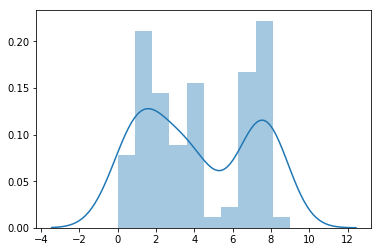

In [82]:
sns.distplot(af.labels_, bins=len(af.cluster_centers_))

# Below this line old work using ABC

In [11]:
# Targets from Dias, 2014 from HL1-6 myocyte
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

In [12]:
# Treat each entry as a separate experiment
for k, _ in exp.items():
    exp[k] = k

In [13]:
limits = {'ik1.g_K1': (0, 0.1),
          'incx.k_NCX': (0, 10),
          'icab.g_Cab': (0, 0.001),
          'inab.g_Nab': (0, 0.01),
          'inak.i_NaK_max': (0, 10)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [14]:
parameters = [k for k in limits.keys()]

In [15]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

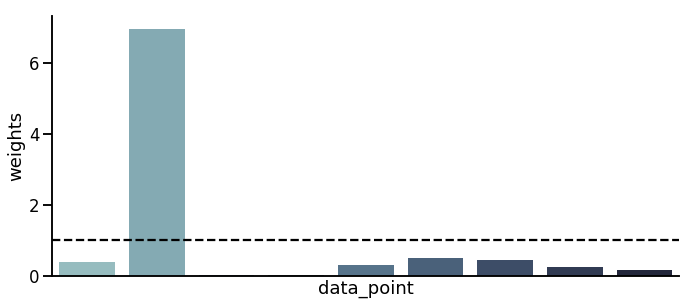

In [17]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)

In [23]:
g.savefig('results/extra/dist_weights.pdf')

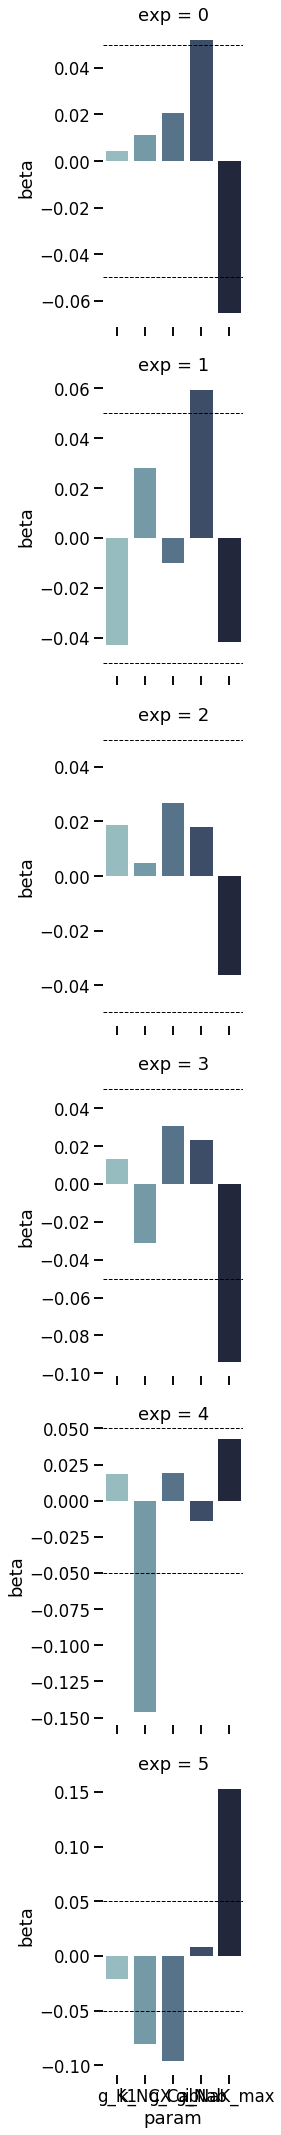

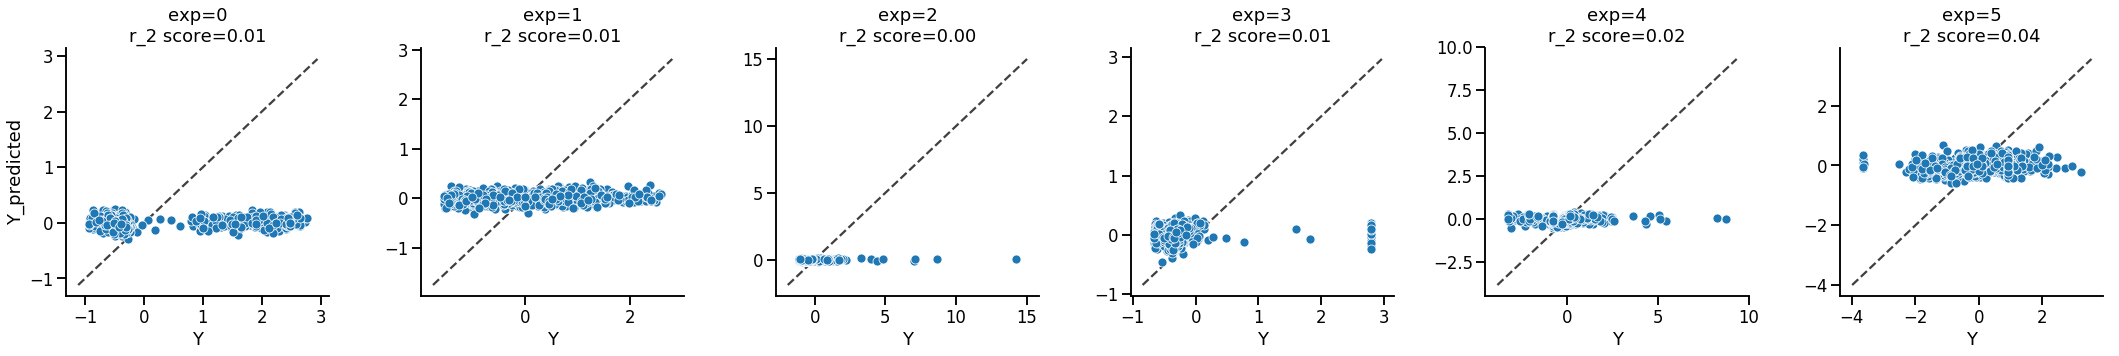

In [19]:
sns.set_context('talk')
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [21]:
grid1.savefig('results/extra/sensitivity.pdf')
grid2.savefig('results/extra/sensitivity_fit.pdf')

# Initialise database

In [24]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_extra.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_extra.db


In [25]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [29]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.2,
                 max_population_size=5000,
                 min_population_size=1000),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 1.1404646574257016, 1: 0.9110130182232632, 2: 1.4404380578249967, 3: 1.2945462193823218, 4: 0.7450225300491324, 5: 0.4685155170945848}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [30]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-09-14 13:18:18.737794, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 200.87939134102186


In [31]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:200.87939134102186
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 9993
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
DEBUG:Epsilon:new eps, t=1, eps=123.61683877239763
INFO:ABC:t:1 eps:123.61683877239763
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:12 eps:20.830361820418144
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/smc.py:735: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 3624 -> 3324
DEBUG:ABC:now submitting population 12


# There be dragons below this line

In [17]:
db_path = 'sqlite:///results/extra/hl-1_extra.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-09-14 13:18:18.737794, end_time=2018-09-16 06:10:38.070834)>]

In [18]:
history.id = 1

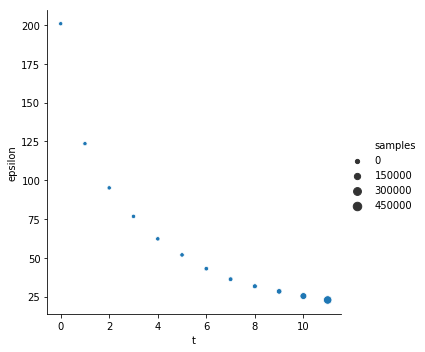

In [20]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/extra/eps_evolution.pdf')

In [21]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


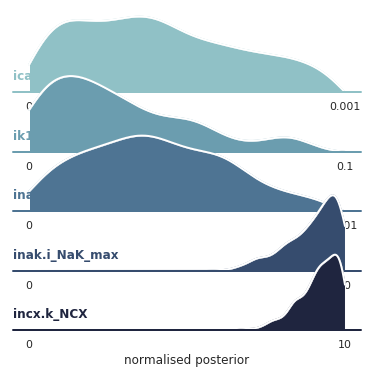

In [22]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

# Samples for quantitative analysis

In [23]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [24]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

In [49]:
samples.head(10)

,x,y,exp,sample,distribution
0,v_rest,-72.600349,0,0,post
1,apa,65.849372,1,0,post
2,apd90,32.928206,1,0,post
3,t_ca_rise,33.988549,1,0,post
4,t_ca50,169.195737,1,0,post
5,t_ca90,517.177638,1,0,post
6,v_rest,-67.131148,0,1,post
7,apa,100.715256,1,1,post
8,apd90,44.143484,1,1,post
9,t_ca_rise,53.588382,1,1,post


In [59]:
vrest = samples[samples.x=='v_rest']['y'].tolist()

In [40]:
import scipy.stats as st
rv = st.rv_discrete(values=(vrest, [1/len(vrest),]*len(vrest)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -66.60421793886735
95% CI: (-75.30694287943668, -29.442153929391555)


In [41]:
apa = samples[samples.x=='apa']['y'].tolist()

In [42]:
rv = st.rv_discrete(values=(apa, [1/len(apa),]*len(apa)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 80.2287999362719
95% CI: (41.753830866930244, 120.0913750932688)


In [43]:
apd90 = samples[samples.x=='apd90']['y'].tolist()

In [45]:
rv = st.rv_discrete(values=(apd90, [1/len(apd90),]*len(apd90)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 39.41153523695539
95% CI: (0.0, 101.86886655577109)


In [47]:
t_ca_rise = samples[samples.x=='t_ca_rise']['y'].tolist()

In [48]:
rv = st.rv_discrete(values=(t_ca_rise, [1/len(t_ca_rise),]*len(t_ca_rise)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 48.426670180255314
95% CI: (5.226285108743468, 713.1389478650817)


In [50]:
t_ca50 = samples[samples.x=='t_ca50']['y'].tolist()

In [51]:
rv = st.rv_discrete(values=(t_ca50, [1/len(t_ca50),]*len(t_ca50)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 176.78167168342043
95% CI: (69.36989630977041, 749.8859521012928)


In [55]:
t_ca90 = samples[samples.x=='t_ca90']['y'].tolist()

In [54]:
rv = st.rv_discrete(values=(t_ca90, [1/len(t_ca90),]*len(t_ca90)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 459.1445368710847
95% CI: (0.0, 914.6406057502318)


## Plot sample of voltage traces

In [22]:
# Manual settings
for sample in param_samples:
    sample['ik1.g_K1'] = 2.108099e-02 #0.024 produced appropriate levels for Ca_i and Na_i
    sample['incx.k_NCX'] = 6.487460e-16#2.268e-16
    sample['icab.g_Cab'] = 5.131545e-04#0.0008
    sample['inab.g_Nab'] = 5.466241e-03
    sample['inak.i_NaK_max'] = 8.424755e+00

In [ ]:
from pyabc_custom import simulate
import seaborn as sns
import numpy as np
import pandas as pd

output_samples = pd.DataFrame()
n_failures = 0
for i, sample in enumerate(param_samples):
    try:
        output = simulate('hl1', exp_num=0, **sample)
    except:
        n_failures = n_failures + 1
        continue
    output['sample'] = i
    output_samples = output_samples.append(output,
                                           ignore_index=True)
print('There were ' + str(n_failures) + ' failed simulations.')

In [11]:
np.mean(output_samples.iloc[range(4,len(output_samples),5)]['0'])
output_samples

,0,exp,sample
0,-62.527795,1,0
1,77.690835,1,0
2,15.163040,1,0
3,106.822245,1,0
4,143.193779,1,0
5,-70.669496,1,1
6,1.447346,1,1
7,-69.222150,1,1
8,1000.000000,1,1
9,0.000000,1,1


In [10]:
sns.set_context('paper')
sns.set_style('white')

y_var = 'membrane.V'

grid = sns.lineplot(data=output_samples,
                    x="environment.time", y=y_var,
                    #units="sample", 
                    estimator=np.mean, 
                    err_style="band", ci="sd",
                    color="black")
grid.set_xlabel('time, ms')
grid.set_ylabel('variable, AU')
for l in grid.axes.lines:
    l.set_linestyle('--')
plt.tight_layout()
#plt.savefig('pulse_train_Ca.pdf', format='pdf', dpi=1000)

final_time = max(output_samples['environment.time'])

print('Variable: ' + y_var)
men = np.mean(output_samples[output_samples['environment.time']==final_time][y_var])
print('Mean: ' + str(men))
sd = np.std(output_samples[output_samples['environment.time']==final_time][y_var])
print('Standard Deviation: ' + str(sd))
med = np.median(output_samples[output_samples['environment.time']==final_time][y_var])
print('Median: ' + str(med))
perc = np.percentile(output_samples[output_samples['environment.time']==final_time][y_var], [75,25])
print('Interquartile range: ' + str(perc[0]-perc[1]))

ValueError: Could not interpret input 'environment.time'

In [7]:
# Manual settings
for sample in param_samples:
    sample['ik1.g_K1'] = 0.024 #0.024 produced appropriate levels for Ca_i and Na_i
    sample['incx.k_NCX'] = 5e-16#2.268e-16
    sample['icab.g_Cab'] = 0.0001#0.0008
    sample['inab.g_Nab'] = 0.005
    sample['inak.i_NaK_max'] = 4